# Using Pyreal - Student Performance
---
In this demonstration, we will be working with the Student Performance Dataset[^1], which predicts the likelihood of students failing a class. We will be taking on the role of a **Pyreal User**, who is just looking to understand their model without a deep understanding of machine learning.

## Scenario Details
### Goals for this Scenario
1. Identify students at risk of failure
2. Identify the risk factors indicative of this risk
3. Identify which factors are associated with higher levels of success

### User Details

- **User Role:** Teacher
- **Expertise:**
    - **Domain (Education):** Expert
    - **Machine Learning:** Minimal
    - **Explainable ML techniques:** Minimal

[^1]: P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance. In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7.


## Data Preparation

We will begin by loading in a premade `RealApp` object for this scenario. This object was created by a `Pyeral Developer`, or another user with some understanding of machine learning. This may be the same person who originally trained our ML model.

We will also load in information about our class of 10 students that we want to learn more about.

In [1]:
from pyreal.sample_applications import student_performance
from pyreal import visualize

real_app = student_performance.load_app()
students = student_performance.load_students()

students

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


,name,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,Jessica González,GP,F,15,U,LE3,T,1,1,at_home,...,yes,yes,no,4,3,2,2,3,3,6
1,Lucia Thompson,GP,F,15,U,GT3,T,4,2,health,...,yes,yes,yes,3,2,2,1,1,5,0
2,Lincoln Bennet,GP,M,16,U,GT3,T,3,3,other,...,yes,no,no,4,3,2,1,2,5,0
3,Lily Perkins,MS,F,18,R,GT3,T,4,4,other,...,yes,yes,yes,3,2,2,4,2,5,0
4,Trevor Butler,GP,M,17,R,GT3,T,3,2,other,...,yes,yes,yes,4,4,4,1,4,3,4
5,Rebeca Guzmán,MS,F,17,R,GT3,T,1,1,other,...,no,yes,no,5,4,4,2,2,5,0
6,Arianna Larson,MS,F,16,U,GT3,T,3,1,other,...,yes,yes,no,3,1,3,1,3,1,0
7,Alberto Luna,MS,M,16,U,GT3,T,3,2,services,...,yes,yes,no,3,1,3,1,4,3,2
8,Laura Tyler,MS,F,17,U,GT3,T,4,2,other,...,yes,yes,no,4,3,3,1,2,4,0
9,Adelyn Baker,MS,F,17,U,GT3,T,4,2,teacher,...,yes,yes,yes,4,2,3,3,1,5,0


Let's begin by seeing which students our model believe are at risk of failure. Here, a prediction of 0 means "failure", while a prediction of 1 means "no failure"

In [2]:
predictions = real_app.predict(students)
predictions

{'Jessica González': 1,
 'Lucia Thompson': 1,
 'Lincoln Bennet': 1,
 'Lily Perkins': 0,
 'Trevor Butler': 0,
 'Rebeca Guzmán': 0,
 'Arianna Larson': 0,
 'Alberto Luna': 0,
 'Laura Tyler': 1,
 'Adelyn Baker': 1,
 'Andre Kim': 1}

Looks like five students are predicted to be at risk of failure. Let's take a closer look at Trevor Butler, to see where his prediction comes from. This RealApp is set up to have "name" as the row id column, so we can access the needed explanation with the name.

We will add the model's positive prediction to the title of the plot to make the plot more clear. We will also flip colors, which will make

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


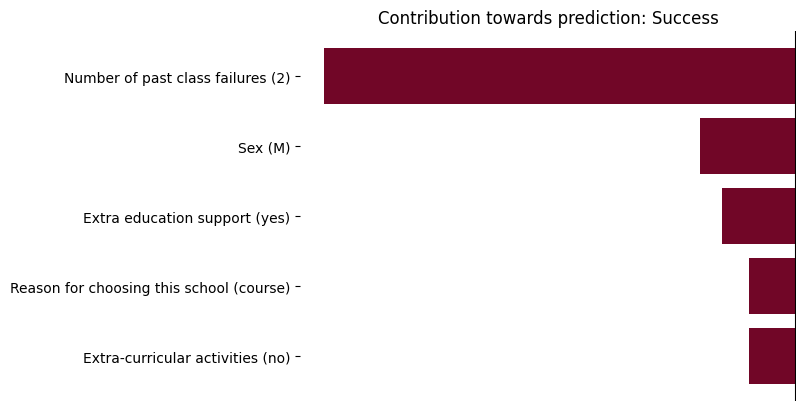

In [3]:
local_explanations = real_app.produce_local_feature_contributions(students)
visualize.plot_top_contributors(local_explanations["Trevor Butler"], prediction="Success")

We can see that Trevor's two past failure is greatly increasing his prediction towards failure. There is also a slight increase in risk for him being a male, receiving extra support, his lack of extra-curricular activities, and the fact that he chose the school do to course preference.

In [4]:
visualize.feature_scatter_plot(local_explanations, "Reason for choosing this school", predictions)

ValueError: Data must be 1-dimensional

In [ ]:
global_explanation = real_app.produce_global_feature_importance()
plot_top_contributors(global_explanation)

In [ ]:
local_explanation = real_app.produce_local_feature_contributions(x)

plot_top_contributors(local_explanation[0])

Now, we will create the transformers. The first will encode boolean features as integers, the second will one hot encode categorical features, and the first with standardize the data.

Some transformation and explanation type combos require post-hoc transformations on the explanations themselves. In this case, we will run SHAP on the one-hot-encoded features, and then recombine the contributions of these features. The OneHotEncoderWrapper includes this functionality.

We can test the accuracy of the model

In [ ]:
from pyreal.visualize import swarm_plot

swarm_plot(local_explanation, n=5, type="strip", discrete=True)

Finally, we fit our explainer, and take a look at the most predictive features.

We can also generate a global feature importance explanation, that summarizes the overall importance of features across all inputs.
